#### Contexto

<img src="https://chargebacks911.com/wp-content/uploads/2023/02/Fraud-Detection-blog.jpg" width="700"/>

Os prejuizos com fraudes financeiras atingiram a marca de R$2,5 bilhões em 2022, segundo o Banco Central.

Fonte: [https://exame.com/inteligencia-artificial/...](https://exame.com/inteligencia-artificial/com-r-25-bi-em-prejuizos-por-fraudes-bc-estuda-responsabilizar-bancos-por-golpes-ia-pode-ajudar/)

Segundo pesquisa realizada pela Confederação Nacional de Dirigentes Lojistas (CNDL) e pelo Serviço de Proteção ao Crédito (SPC Brasil), 8,4 milhões de pessoas sofreram algum tipo de fraude no ano de 2022, sendo 4% desses, vítimas de fraudes por transações bancárias.

Fonte: [https://site.cndl.org.br/8-milhoes-de-consumidores...](https://site.cndl.org.br/8-milhoes-de-consumidores-sofreram-golpes-financeiros-nos-ultimos-12-meses-aponta-cndl-spc-brasil/)

Um estudo conduzido pela Juniper Research prevê que os gastos com tecnologias para detectar fraudes excederão US$ 10 bilhões globalmente em 2027.

Fonte: [https://inforchannel.com.br/2022/11/19/gastos-com-deteccao-de-fraudes](https://inforchannel.com.br/2022/11/19/gastos-com-deteccao-de-fraudes-financeiras-com-ia-somarao-us-10-bi-em-2027/)


#### Objetivo
Criar um modelo de detecção de fraudes financeiras utilizando técnicas de aprendizado de máquina supervisionado.

Para o estudo será usado um banco de dados disponibilizado pela Tera com dados gerados sintéticamente e este será conduzido da seguinte forma:

* Análise exploratória dos dados
* Pré-processamento dos dados
* Implementação e análise do modelo
* Conclusão

As linhas de código abaixo carregam as bibliotecas necessárias e a base de dados para o estudo.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import missingno as msno

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import ADASYN
from collections import Counter
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans
from imblearn.combine import SMOTEENN

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data/fraud_database.csv")

Para uso posterior, é criada a função model_evaluation.

In [3]:
estrategy_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1score_list = []
auc_list = []


def model_evaluation(y_test, y_pred, model_function, model_name):
    accuracy =  accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    estrategy_list.append(model_name)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1score_list.append(f1score)
    auc_list.append(auc)

    results = pd.DataFrame({'Estrategy' : estrategy_list,
                 'accuracy' : accuracy_list,
                 'precision' : precision_list,
                 'recall' : recall_list,
                 'F1 score' : f1score_list,
                'AUC' : auc_list
              })    

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_function.classes_)
    disp.plot(values_format='d')

    cr = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
    print(cr)

    print(results)

    

#### Análise exploratória dos dados

Nesta seção serão exploradas as características básicas dos datasets, como dimensões e variáveis.  
Uma amostra do banco de dados é apresentada.

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Verificação das variáveis contidas no banco de dados e os tipos dos dados. Esse dataset contém 6362620 linhas e 11 colunas.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


"type" é uma variável categórica que indica qual o tipo de transação que foi realizada. Abaixo é verificado os possíveis tipos de transação, sendo eles:

* **CASH_OUT**: Saída de dinheiro
* **PAYMENT**: Pagamento
* **CASH_IN**: Entrada de dinheiro
* **TRANSFER**: Transferência Bancária
* **DEBIT**: Débito

In [6]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

São apresentados os percentuais de cada tipo de transação no dataset.

In [26]:
for i in range(len(df['type'].value_counts())):
    perc = (df['type'].value_counts().iloc[i] / df.shape[0]) * 100
    var = df['type'].value_counts().index[i]
    print("{}: {:.2f}%".format(var, perc))

CASH_OUT: 35.17%
PAYMENT: 33.81%
CASH_IN: 21.99%
TRANSFER: 8.38%
DEBIT: 0.65%


A variável "isFraud" será a variável resposta, ou seja, o que deseja-se prever. A partir deste ponto será tratada como "y". O valor dessa variável pode ser "0", significando que a transação é normal ou "1" indicando que é fraudulenta.
É apresentado o percentual de transações que são classificadas como normais e fraudes.

In [27]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [31]:
y_fraud_perc = (df[df['isFraud'] == 1].value_counts().sum() / df.shape[0]) * 100
y_not_fraud_perc = 100 - y_fraud_perc
print("{:.2f}% dos dados são de transações apontadas como normais e apenas {:.2f}% são fraudes."
      .format(y_not_fraud_perc, y_fraud_perc))

99.87% dos dados são de transações apontadas como normais e apenas 0.13% são fraudes.


Verificou-se que o dataset é desbalanceado. Como os algorítmos de machine learning assumem que o dataset é balanceado, faz-se necessário balancear os dados.  
Abaixo é apresentado um gráfico de dispersão, onde os valores das transações estão na ordenada (eixo vertical). Nota-se que os valores das transações fraudulentas encontram-se abaixo de 2e+07.

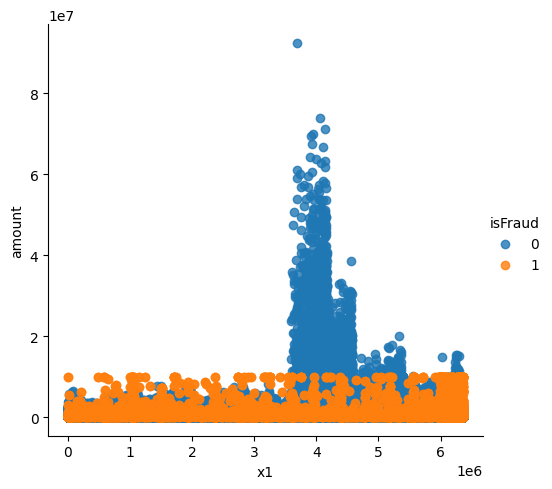

In [32]:
df['x1'] = df.index
sns.lmplot(x='x1', y='amount', data=df, hue='isFraud', fit_reg=False)

As variáveis originalmente categóricas que estavam como numéricas tiveram suas categorias alteradas.

In [34]:
df['step'] = df['step'].astype('category')
df['type'] = df['type'].astype('category')
df['nameOrig'] = df['nameOrig'].astype('category')
df['nameDest'] = df['nameDest'].astype('category')
df['isFraud'] = df['isFraud'].astype('category')
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype('category')

Abaixo é verificado se existem valores faltantes e conclui-se que não há.

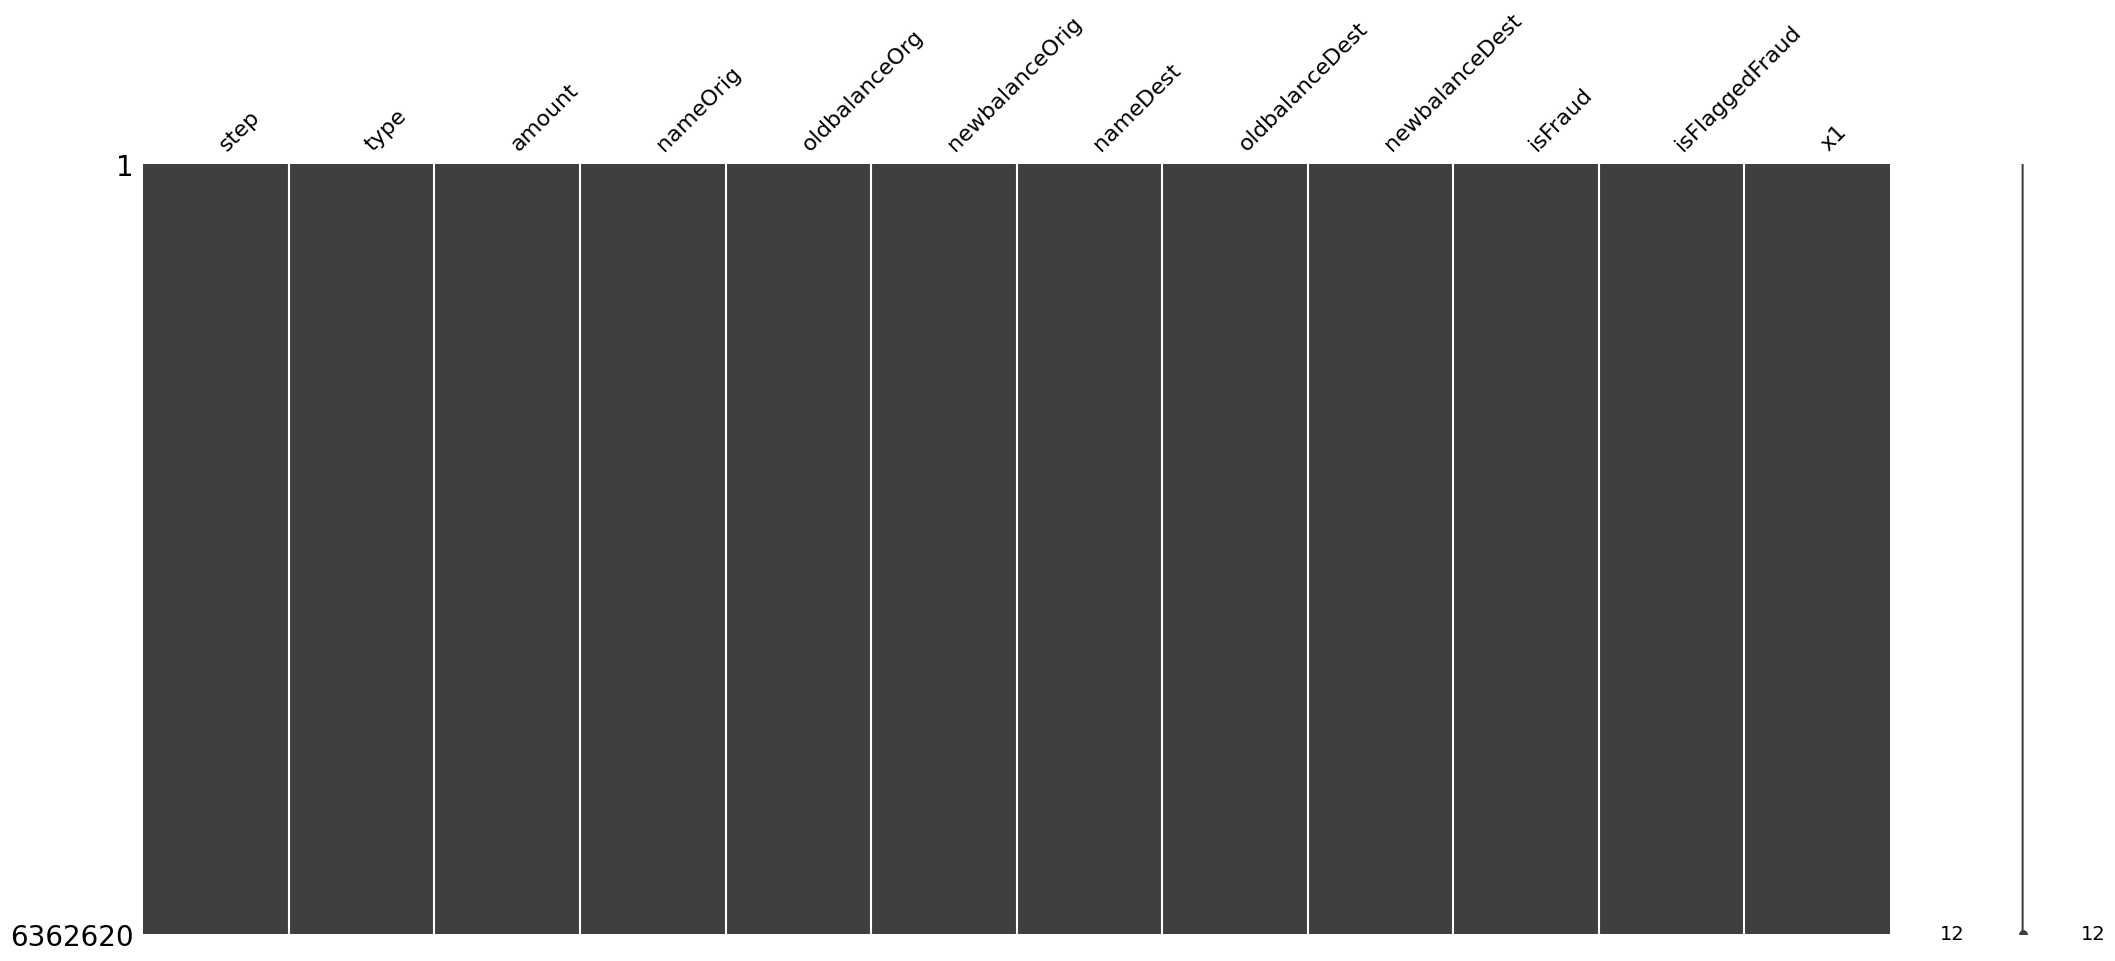

In [36]:
msno.matrix(df)
plt.show()

Ao analisar o boxplot verifica-se uma assimetria dos dados, uma vez que a linha da mediana aproxima-se do 1º quartil, indicando ser uma distribuição assimetrica positiva. Apesar da existência de outliers a amplitude dos dados  relativamente baixa, com 50% dos dados estando entre 1.27e+05 e 1.52e+06.

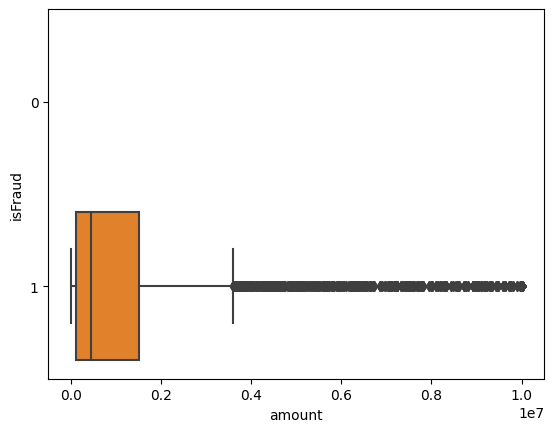

In [51]:
sns.boxplot(
data=df[df['isFraud'] == 1],
x='amount',
y='isFraud',
orient='h'
)
plt.show()

A média dos dados indicados como fraude é 14.7e+05 e a mediana 4,41e+05, que reforça a representação gráfica apresentada acima.

In [69]:
df_isfraud.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,x1
count,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03
mean,1.467967e+06,1.649668e+06,1.923926e+05,5.442496e+05,1.279708e+06,4.244980e+06
std,2.404253e+06,3.547719e+06,1.965666e+06,3.336421e+06,3.908817e+06,2.157498e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
25%,1.270913e+05,1.258224e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.065130e+06
50%,4.414234e+05,4.389835e+05,0.000000e+00,0.000000e+00,4.676420e+03,5.188057e+06
75%,1.517771e+06,1.517771e+06,0.000000e+00,1.478287e+05,1.058725e+06,6.168689e+06
99%,1.000000e+07,1.549020e+07,5.617708e+06,9.342000e+06,1.181407e+07,6.362537e+06
max,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,6.362619e+06


Para realizar análise sobre os dados apontados como fraude, será criado um dataset somente com esses dados.

In [48]:
df_isfraud = df[df['isFraud'] == 1].copy(deep=True)

In [55]:
df_cat = df.select_dtypes(include='category')
df_num = df.select_dtypes(exclude='category')

In [73]:
df_cat.head()

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud
0,1,PAYMENT,C1231006815,M1979787155,0,0
1,1,PAYMENT,C1666544295,M2044282225,0,0
2,1,TRANSFER,C1305486145,C553264065,1,0
3,1,CASH_OUT,C840083671,C38997010,1,0
4,1,PAYMENT,C2048537720,M1230701703,0,0


#### Pré-processamento dos dados

Para ser possível usar as variáveis categóricas no algorítmo, é necessário transformá-las em númericas. Para tal, foi utilizada a técnica de One-Hot Enconding somente na variável "type" pois as variáveis "nameOrig" e "nameDest" possuem um elevado volume de dados não únicos, sendo difícil de associá-los a fraudes por ser difícil de identicar um padrão.  

Abaixo realiza-se a cópia da coluna 'type' para aplicaçãod do One Hot Encoding.

In [62]:
df_encoding = df_cat['type'].copy(deep=True)

A técnica de One Hot Encoding é instânciada e então aplicada aos dados. Após isso o rótulo dos dados é aplicado ao resultado.

In [64]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [65]:
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_encoding.values.reshape(-1, 1)))

In [75]:
OH_cols.index = df_encoding.index

In [78]:
OH_cols.columns = OH_encoder.get_feature_names_out(['type'])

In [80]:
OH_cols.head(2)

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0


A coluna que iniciamente foi criada para plotar o gráfico de dispersão é removida, pois não será mais usada e as colunas criadas a partir do One Hot Encoding são agrupadas ao banco de dados com os variáveis numéricas.

In [81]:
df_num.drop(['x1'], axis=1, inplace=True)

In [82]:
OH_df_num = pd.concat([df_num, OH_cols], axis=1)

In [83]:
OH_df_num.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,181.00,181.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,181.00,181.0,0.00,21182.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Abaixo é criado o dataset que será usado para a criação do modelo. Esse dataset contém as variáveis numéricas e a variável resposta.

In [84]:
df_model = pd.concat([OH_df_num, df['isFraud']], axis=1)

In [88]:
df_model.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,181.00,181.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,181.00,181.0,0.00,21182.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


Como mencionado anteriormente, o banco de dados é muito desbalanceado, por isso deverá ser aplicado técnicas de balanceamento.
Antes disso, o banco de dados será divido entre treino e teste, sendo 77% dos dados para treino e 33% para teste. Os dados de treino serão usados para treinar o modelo e os dados de teste serão usados para posterior análise das métricas do modelo.

In [90]:
X = df_model.drop(columns=['isFraud'])
y = df_model.isFraud

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.33,
                                                    random_state=42)

#### Implementação e análise do modelo

Dado que a variável resposta é categórica binária, fraude, sim ou não, opta-se pelo uso da regressão logística para criação do modelo. Esse algorítmo irá estimar a probabilidade de uma transação pertencer a transações fraudulentas ou não.

A avaliação do modelo será feita com as métricas de acurácia, precisão, recall, F1 score e área abaixo da curva (AUC). Para comparar as métricas entre os modelos, foi definida a função "model_evaluation".

Inicialmente criou-se o modelo baseline, sendo o modelo mais simples possível. Esse modelo foi criado a partir dos dados originais, ou seja, desbalanceados. O modelo baseline será usado como referência para verificar se as técnicas de balanceamento aplicadas resultam em melhores resultados ou não.

**Baseline Model:**

In [93]:
logreg_baseline = LogisticRegression(max_iter=200)
logreg_baseline.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [94]:
y_pred_baseline = logreg_baseline.predict(X_test)

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   2096999
       Fraud       0.33      0.80      0.46      2666

    accuracy                           1.00   2099665
   macro avg       0.66      0.90      0.73   2099665
weighted avg       1.00      1.00      1.00   2099665

  Estrategy  accuracy  precision   recall  F1 score       AUC
0  baseline  0.997641   0.325553  0.80045  0.462857  0.899171


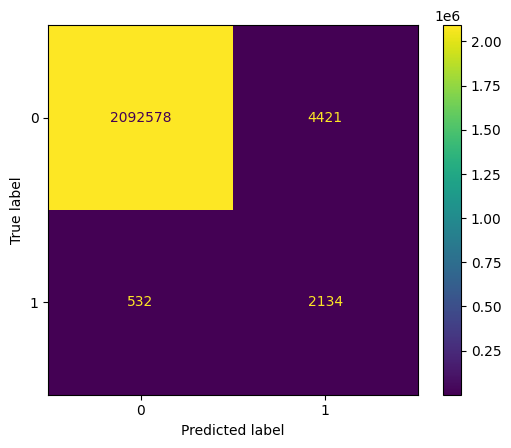

In [95]:
model_evaluation(y_test, y_pred_baseline, logreg_baseline, 'baseline')

O modelo baseline apresentou acurácia de 99,76%. Essa métrica expressa a porcentagem de amostras que foram classificadas como fraudes e não fraudes que verdadeiramente são isso, porém a precisão foi baixa, sendo 32,5%. A precisão indica o quanto o modelo acertou ao identicar as fraudes. Nesse caso, o modelo identificou 2134 fraudes que realmente eram fraudes, porém identificou 4421 transações normais como fraude. Recall é a taxa de detecção, de todas as amostras de fraudes que o modelo poderia detectar, quantas ele realmente detectou. O recall desse modelo foi de 80,0%.  
F1 Score é uma métrica que relaciona precisão e recall, quanto mais próximo de 1, melhor o valor dessa métrica.  
O AUC indica a eficácia do classificador. Uma AUC igual a 1 indica uma classificação perfeita, ou seja, todas as fraudes foram detectadas corretamente e não nenhuma transação normal foi detectada como fraude. Assim, o presente modelo com AUC de 0.90, demonstra uma ótima eficácia em detectar fraudes.

Abaixo serão usadas técnicas para balancear as amostras. E posteriormente serão avaliados os modelos gerados a partir dessas técnicas.

**Balanceamento automático de classes:**

In [96]:
logreg_balanced = LogisticRegression(class_weight='balanced')
logreg_balanced.fit(X_train, y_train)
y_pred_balanced = logreg_balanced.predict(X_test)

              precision    recall  f1-score   support

   Not Fraud       1.00      0.81      0.89   2096999
       Fraud       0.01      0.98      0.01      2666

    accuracy                           0.81   2099665
   macro avg       0.50      0.89      0.45   2099665
weighted avg       1.00      0.81      0.89   2099665

          Estrategy  accuracy  precision    recall  F1 score       AUC
0          baseline  0.997641   0.325553  0.800450  0.462857  0.899171
1  balanced classes  0.806749   0.006416  0.982746  0.012749  0.894636


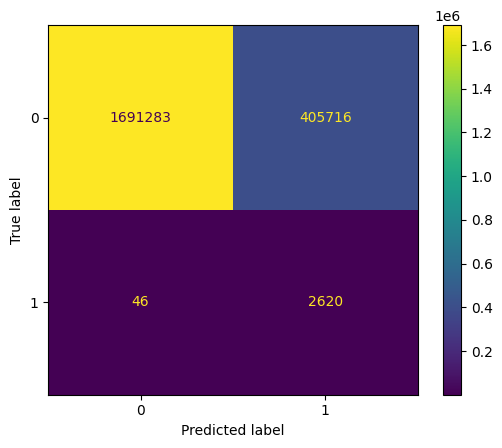

In [97]:
model_evaluation(y_test, y_pred_balanced, logreg_balanced, 'balanced classes')

O modelo com classes balanceadas automaticamente apresentou um grande número de falsos positivos, tornando a precisão do modelo em identificar fraudes muito baixa. Essa precisão muito baixa pode tornar a experiência do cliente muito ruim, pois muitas de suas transações normais serão apontadas como fraude. O modelo baseline apresentou uma performance melhor.

Abaixo é usada a técnica de grid research para identificar o balanceamento que otimiza a métrica de F1 score.

In [112]:
weights = np.linspace(0.0, 0.99, 50)

param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

gridsearch = GridSearchCV(estimator= logreg_baseline,
                          param_grid= param_grid,
                          n_jobs= -1,
                          scoring='f1').fit(X_train, y_train)


In [113]:
print("customized balanced classes parameters: {}".format(gridsearch.best_params_))
print("best F1 Score is: {}".format(gridsearch.best_score_))

customized balanced classes parameters: {'class_weight': {0: 0.8687755102040816, 1: 0.1312244897959184}}
best F1 Score is: 0.8019032553267363


**Balanceamento de classes customizado** com os pesos das classes obtidas através da técnica de grid search. O grid search foi usado buscando otimizar a métrica de F1 score.

In [99]:
logreg_customized = LogisticRegression(class_weight={0: 0.87, 1: 0.13})

In [100]:
logreg_customized.fit(X_train, y_train)
y_pred_customized = logreg_customized.predict(X_test)

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   2096999
       Fraud       0.96      0.70      0.81      2666

    accuracy                           1.00   2099665
   macro avg       0.98      0.85      0.91   2099665
weighted avg       1.00      1.00      1.00   2099665

                     Estrategy  accuracy  precision    recall  F1 score  \
0                     baseline  0.997641   0.325553  0.800450  0.462857   
1             balanced classes  0.806749   0.006416  0.982746  0.012749   
2  Customized Balanced Classes  0.999585   0.960493  0.702176  0.811268   

        AUC  
0  0.899171  
1  0.894636  
2  0.851069  


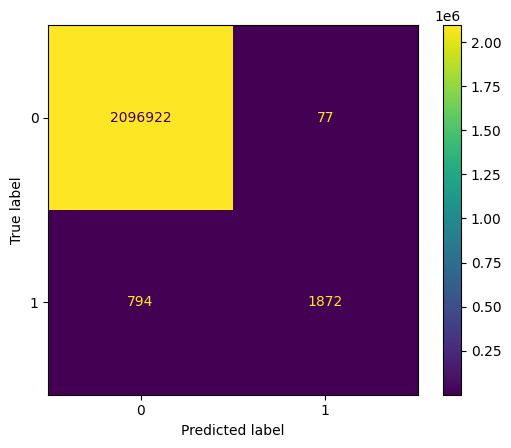

In [101]:
model_evaluation(y_test, y_pred_customized, logreg_customized, 'Customized Balanced Classes')

O modelo com balanceamento customizado apresentou o melhor resultado considerando os valores encontrados em cada métrica.  
A precisão foi de 96,0%, a melhor comparada com os modelos anteriores. 1872 verdadeiramente fraudes foram identificadas e somente 77 transações normais foram classificadas como fraude. Porém, 794 fraudes foram classificadas como transações normais, tendo uma métrica de recall pior quando comparada com os modelos anteriores.

#### Técnicas de reamostragem do dataset

**Over-sampling**

ADASYN (Adaptative Synthetic Algorithm)

O código abaixo realiza a reamostragem dos dados e cria o modelo a partir desse novo banco de dados.

In [103]:
adasyn = ADASYN(random_state=42, sampling_strategy=0.22)
X_over, y_over = adasyn.fit_resample(X_train, y_train)
print("Resultado após o oversampling %s" % Counter(y_over))

Resultado após o oversampling Counter({0: 4257408, 1: 936253})


              precision    recall  f1-score   support

   Not Fraud       1.00      0.91      0.95   2096999
       Fraud       0.01      0.98      0.03      2666

    accuracy                           0.91   2099665
   macro avg       0.51      0.94      0.49   2099665
weighted avg       1.00      0.91      0.95   2099665

                         Estrategy  accuracy  precision    recall  F1 score  \
0                         baseline  0.997641   0.325553  0.800450  0.462857   
1                 balanced classes  0.806749   0.006416  0.982746  0.012749   
2      Customized Balanced Classes  0.999585   0.960493  0.702176  0.811268   
3  Over Sampling - ADASYN (22:100)  0.908251   0.013401  0.981245  0.026441   

        AUC  
0  0.899171  
1  0.894636  
2  0.851069  
3  0.944702  


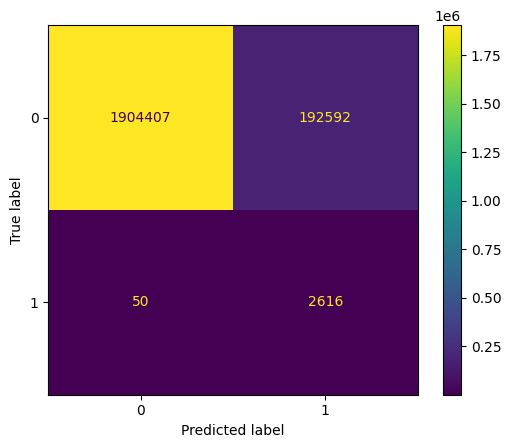

In [104]:
logreg_baseline.fit(X_over, y_over)
y_pred_adasyn = logreg_baseline.predict(X_test)
model_evaluation(y_test, y_pred_adasyn, logreg_baseline, 'Over Sampling - ADASYN (22:100)')

A técnica over-sampling trouxe piores resultados de precisão e, consequentemente, F1 score. Ou seja, um grande número de transações normais foram identificadas como fraudulentas, mesmo sendo identificadas grande parte das fraudes.

### Under Sampling

In [106]:
cc = ClusterCentroids(estimator=MiniBatchKMeans(),
                      random_state= 42,
                      sampling_strategy=0.35)

X_under, y_under = cc.fit_resample(X_train, y_train)
print('Resultado após o under sampling %s' % Counter(y_under))

Resultado após o under sampling Counter({0: 15848, 1: 5547})


              precision    recall  f1-score   support

   Not Fraud       1.00      0.90      0.95   2096999
       Fraud       0.01      0.97      0.02      2666

    accuracy                           0.90   2099665
   macro avg       0.51      0.93      0.48   2099665
weighted avg       1.00      0.90      0.94   2099665

                         Estrategy  accuracy  precision    recall  F1 score  \
0                         baseline  0.997641   0.325553  0.800450  0.462857   
1                 balanced classes  0.806749   0.006416  0.982746  0.012749   
2      Customized Balanced Classes  0.999585   0.960493  0.702176  0.811268   
3  Over Sampling - ADASYN (22:100)  0.908251   0.013401  0.981245  0.026441   
4              Under Sampling - CC  0.896180   0.011693  0.966992  0.023106   

        AUC  
0  0.899171  
1  0.894636  
2  0.851069  
3  0.944702  
4  0.931541  


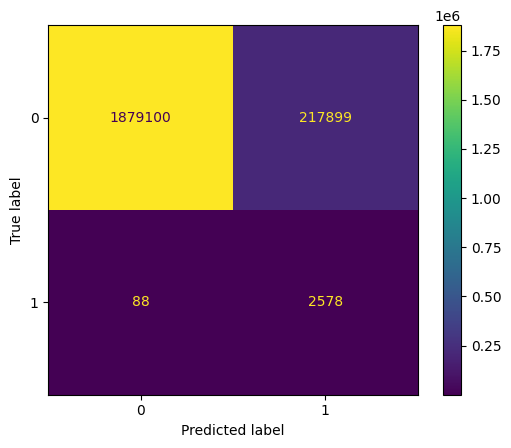

In [107]:
logreg_baseline.fit(X_under, y_under)
y_pred_under_cc = logreg_baseline.predict(X_test)
model_evaluation(y_test, y_pred_under_cc, logreg_baseline, 'Under Sampling - CC')

A técnica de under-sampling também trouxe piores resultados de precisão e, consequentemente, F1 score. Ou seja, um grande número de transações normais foram identificadas como fraudulentas, mesmo sendo identificadas grande parte das fraudes.

### Under Sampling + Over-sampling

In [109]:
sme = SMOTEENN(random_state=42, sampling_strategy=0.1) #proportion 1:10

X_smoteen, y_smoteen = sme.fit_resample(X_train, y_train)

print('Results after under + over sampling strategy: %s' % Counter(y_smoteen))

Results after under + over sampling strategy: Counter({0: 4240211, 1: 418667})


              precision    recall  f1-score   support

   Not Fraud       1.00      0.93      0.96   2096999
       Fraud       0.02      0.95      0.03      2666

    accuracy                           0.93   2099665
   macro avg       0.51      0.94      0.50   2099665
weighted avg       1.00      0.93      0.96   2099665

                         Estrategy  accuracy  precision    recall  F1 score  \
0                         baseline  0.997641   0.325553  0.800450  0.462857   
1                 balanced classes  0.806749   0.006416  0.982746  0.012749   
2      Customized Balanced Classes  0.999585   0.960493  0.702176  0.811268   
3  Over Sampling - ADASYN (22:100)  0.908251   0.013401  0.981245  0.026441   
4              Under Sampling - CC  0.896180   0.011693  0.966992  0.023106   
5   Under and Over Sampling (1:10)  0.929481   0.016809  0.948612  0.033032   

        AUC  
0  0.899171  
1  0.894636  
2  0.851069  
3  0.944702  
4  0.931541  
5  0.939034  


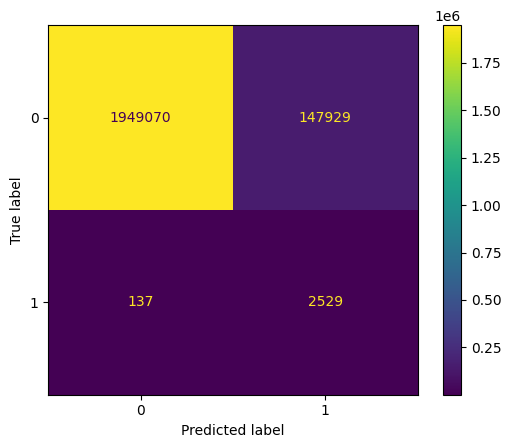

In [110]:
logreg_baseline.fit(X_smoteen, y_smoteen)
y_pred_smoteen = logreg_baseline.predict(X_test)
model_evaluation(y_test, y_pred_smoteen, logreg_baseline, 'Under and Over Sampling (1:10)')

A técnica de under-sampling + over-sampling também trouxe piores resultados de precisão e, consequentemente, F1 score. Ou seja, um grande número de transações normais foram identificadas como fraudulentas, mesmo sendo identificadas grande parte das fraudes.

#### Conclusão

Levando-se em consideração que a técnica de classificação utilizada para criar o modelo foi a regressão logística, e que esse método é eficiente em dados balanceados, buscou-se reduzir a disparidade dos dados com o objetivo de melhorar a performance no modelo em identificar fraudes em transações bancárias. Com isso, obteve-se um modelo capaz de prever fraudes bancárias com acurácia de 99,9%, precisão de 96,0% e recall de 70,2%. Esse modelo foi obtido a partir do balanceamento customizado das classes.